# Identify Field Management Zones from a Collection of NDVI Images nad Soil Moisture Surveys

In this tutorial you will learn how to:

- Find, access, and download products from Google Earth Engine
- Compute NDVI from image bands 
- Load custom field boundaries in vector format
- Plot raster files
- Stack raster files to generate space-time arrays
- Cluster multiple images to generate field management zones
- Export map of resulting field management zones as prescription maps in Shapefile format
- Load points of soil moisture data collected in the field
- Create raster for field
- Interpolate points to raster
- Identify drier and wetter than average zones


### Import necessary modules

In [6]:
# Import modules
import ee
import glob
import requests
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from datetime import datetime, timedelta
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata, RBFInterpolator


### Initialize Google Earth Engine

In [2]:
# Authenticate
ee.Authenticate()

# Initialize API
ee.Initialize()

Enter verification code:  4/1AVG7fiSg2WBEnTdY_KC5CxFdzuk058jd2meoWb_jez0WuRaQ9xQIUnC6uo4



Successfully saved authorization token.


### Create helper functions

In [3]:
def save_gee_to_geotiff(ee_image, filename, crs, scale, geom, bands=[]):
    """
    Function to save images from Google Earth Engine into local hard drive.
    """
    image_url = ee_image.getDownloadUrl({'region': geom,'scale':scale, 
                                         'bands': bands,
                                         'crs': f'EPSG:{crs}', 
                                         'format': 'GEO_TIFF'})
    
    # Request data using URL and save data as a new GeoTiff file
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
            print(f"Saved image {filename}")
    else:
        print("Failed to download image")


def array_to_df(arr):
    """Function to convert list into dataframe"""
    df = pd.DataFrame(arr[1:])
    df.columns = arr[0]
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    return df


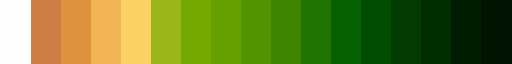

In [4]:
# Create our own colormap
hex_palette = ['#FEFEFE','#CE7E45', '#DF923D', '#F1B555', '#FCD163', '#99B718', '#74A901',
             '#66A000', '#529400', '#3E8601', '#207401', '#056201', '#004C00', '#023B01',
             '#012E01', '#011D01', '#011301']


# Use the built-in ListedColormap function to do the conversion
ndvi_cmap = colors.ListedColormap(hex_palette)
ndvi_cmap

### Define area of interest

We will use a cropland field within the Konza Prairie Biological Station near Manhattan, KS. The field has a site of the National Ecological Observatory Network that you can also use to retrieve additional data.

In [7]:
# Import boundary for area of interest (aoi)
#with open('neon_kona_bnd.geojson') as file:
#    aoi_json = json.load(file)

# Read field boundary with Geopandas
field_bnd = gpd.read_file('mortimers_bnd.geojson')

# Get JSON format (.to_json() gives us a string, so we use the json module to create a proposer json object
roi_json = json.loads(field_bnd.to_json())

# Define the ee.Geometry
roi = ee.Geometry(roi_json['features'][0]['geometry'])

# Create mask for field
mask = ee.Image.constant(1).clip(roi).mask()

In [8]:
# Get centroid so that we can define a point

# Get centroid using GeoPandas
#print(field_bnd.centroid)

# Get centroids from GEE geometry
field_centroid = roi.centroid().getInfo()
print(field_centroid)


{'type': 'Point', 'coordinates': [-97.43482229076969, 38.71414271696167]}


### Get NDVI timeseries to inspect growing season trend

In [9]:
# Define start and end dates
start_date = '2020-01-01'
end_date = '2023-12-01'


In [10]:
# Define point of interest
field_point = ee.Geometry.Point(field_centroid['coordinates'])

In [11]:
# Get collection for Modis 16-day
terra = ee.ImageCollection("MODIS/061/MOD13Q1").filterDate(start_date, end_date).filterBounds(field_point)
ndvi = terra.select('NDVI')
field_ndvi = ndvi.getRegion(field_point, scale=250).getInfo()

In [12]:
# Convert array into dataframe
df_field = array_to_df(field_ndvi)
df_field.head(3)

,id,longitude,latitude,time,NDVI
0,2020_01_01,-97.434644,38.71402,2020-01-01,4582
1,2020_01_17,-97.434644,38.71402,2020-01-17,4417
2,2020_02_02,-97.434644,38.71402,2020-02-02,4105


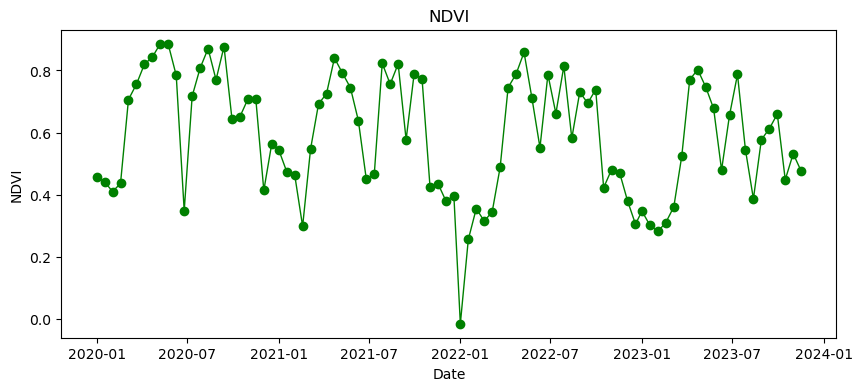

In [13]:
# Create figure to visualize time series
plt.figure(figsize=(10,4))
plt.title('NDVI')
plt.plot(df_field['time'], df_field['NDVI']*0.0001, linestyle='-', linewidth=1, marker='o', color='green')
plt.xlabel('Date')
plt.ylabel('NDVI')
#plt.savefig('evi_figure.png', dpi=300)
plt.show()

### Download Sentinel data

In [14]:
# Re-define start and end dates based on time series
start_date = '2023-01-01'
end_date = '2023-12-01'


In [15]:
# Select Sentinel 2 data
collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterDate(start_date, end_date).filterBounds(roi).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Get the list of available image dates
get_date = lambda image: ee.Image(image).date().format('YYYY-MM-dd')

collection_dates = collection.toList(collection.size()).map(get_date).getInfo()
unique_collection_dates = np.unique(collection_dates)
print(unique_collection_dates)


['2023-01-09' '2023-01-19' '2023-01-27' '2023-02-03' '2023-02-11'
 '2023-02-13' '2023-02-28' '2023-03-03' '2023-04-02' '2023-04-12'
 '2023-04-17' '2023-04-29' '2023-05-07' '2023-05-12' '2023-05-17'
 '2023-06-06' '2023-06-13' '2023-06-18' '2023-06-26' '2023-07-11'
 '2023-07-23' '2023-07-26' '2023-08-07' '2023-08-15' '2023-08-20'
 '2023-08-25' '2023-08-27' '2023-08-30' '2023-09-01' '2023-09-04'
 '2023-09-06' '2023-09-26' '2023-09-29' '2023-10-01' '2023-10-04'
 '2023-10-09' '2023-10-11' '2023-10-16' '2023-10-19' '2023-10-21'
 '2023-11-10' '2023-11-13' '2023-11-18' '2023-11-28']


In [16]:
# Select all or a subset of the collection dates
selected_dates = unique_collection_dates[::3]

# Download each image
for date in selected_dates:
    
    # Define start and end dates
    start_date = date
    end_date = (datetime.strptime(start_date,'%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')

    # Request image
    image = collection.filterDate(start_date, end_date).first().select(['B8', 'B4'])
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI').mask(mask)
    
    save_gee_to_geotiff(ndvi, f'ndvi_data/ndvi_{start_date}.tif', crs=4326, scale=10, geom=roi)



Saved image ndvi_data/ndvi_2023-01-09.tif
Saved image ndvi_data/ndvi_2023-02-03.tif
Saved image ndvi_data/ndvi_2023-02-28.tif
Saved image ndvi_data/ndvi_2023-04-12.tif
Saved image ndvi_data/ndvi_2023-05-07.tif
Saved image ndvi_data/ndvi_2023-06-06.tif
Saved image ndvi_data/ndvi_2023-06-26.tif
Saved image ndvi_data/ndvi_2023-07-26.tif
Saved image ndvi_data/ndvi_2023-08-20.tif
Saved image ndvi_data/ndvi_2023-08-30.tif
Saved image ndvi_data/ndvi_2023-09-06.tif
Saved image ndvi_data/ndvi_2023-10-01.tif
Saved image ndvi_data/ndvi_2023-10-11.tif
Saved image ndvi_data/ndvi_2023-10-21.tif
Saved image ndvi_data/ndvi_2023-11-18.tif


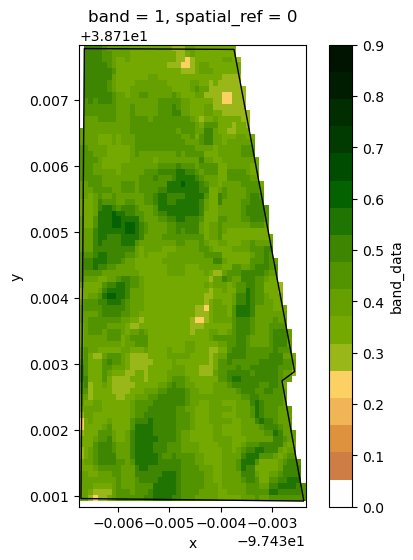

In [17]:
# Read one image to inspect data
da = xr.load_dataarray('ndvi_data/ndvi_2023-09-06.tif').squeeze()

# Get number of rows and columns for later use
img_rows, img_cols = da.shape

# Visualize map for specific date
fig, ax = plt.subplots(figsize=(6,6))
da.plot(ax=ax, cmap=ndvi_cmap, vmin=0.0, vmax=0.9)
field_bnd.plot(ax=ax, facecolor='None')
plt.show()


In [18]:
# Read all image names
files = glob.glob('ndvi_data/*.tif')


In [19]:
data = np.full((img_rows, img_cols, len(selected_dates)), np.nan)
for k,file in enumerate(files):
    da = xr.load_dataarray(file).squeeze()
    data[:,:,k] = da.values

In [20]:
data = xr.DataArray(data=data, coords=[da.y, da.x, pd.to_datetime(selected_dates)], dims=["y", "x", "date"])

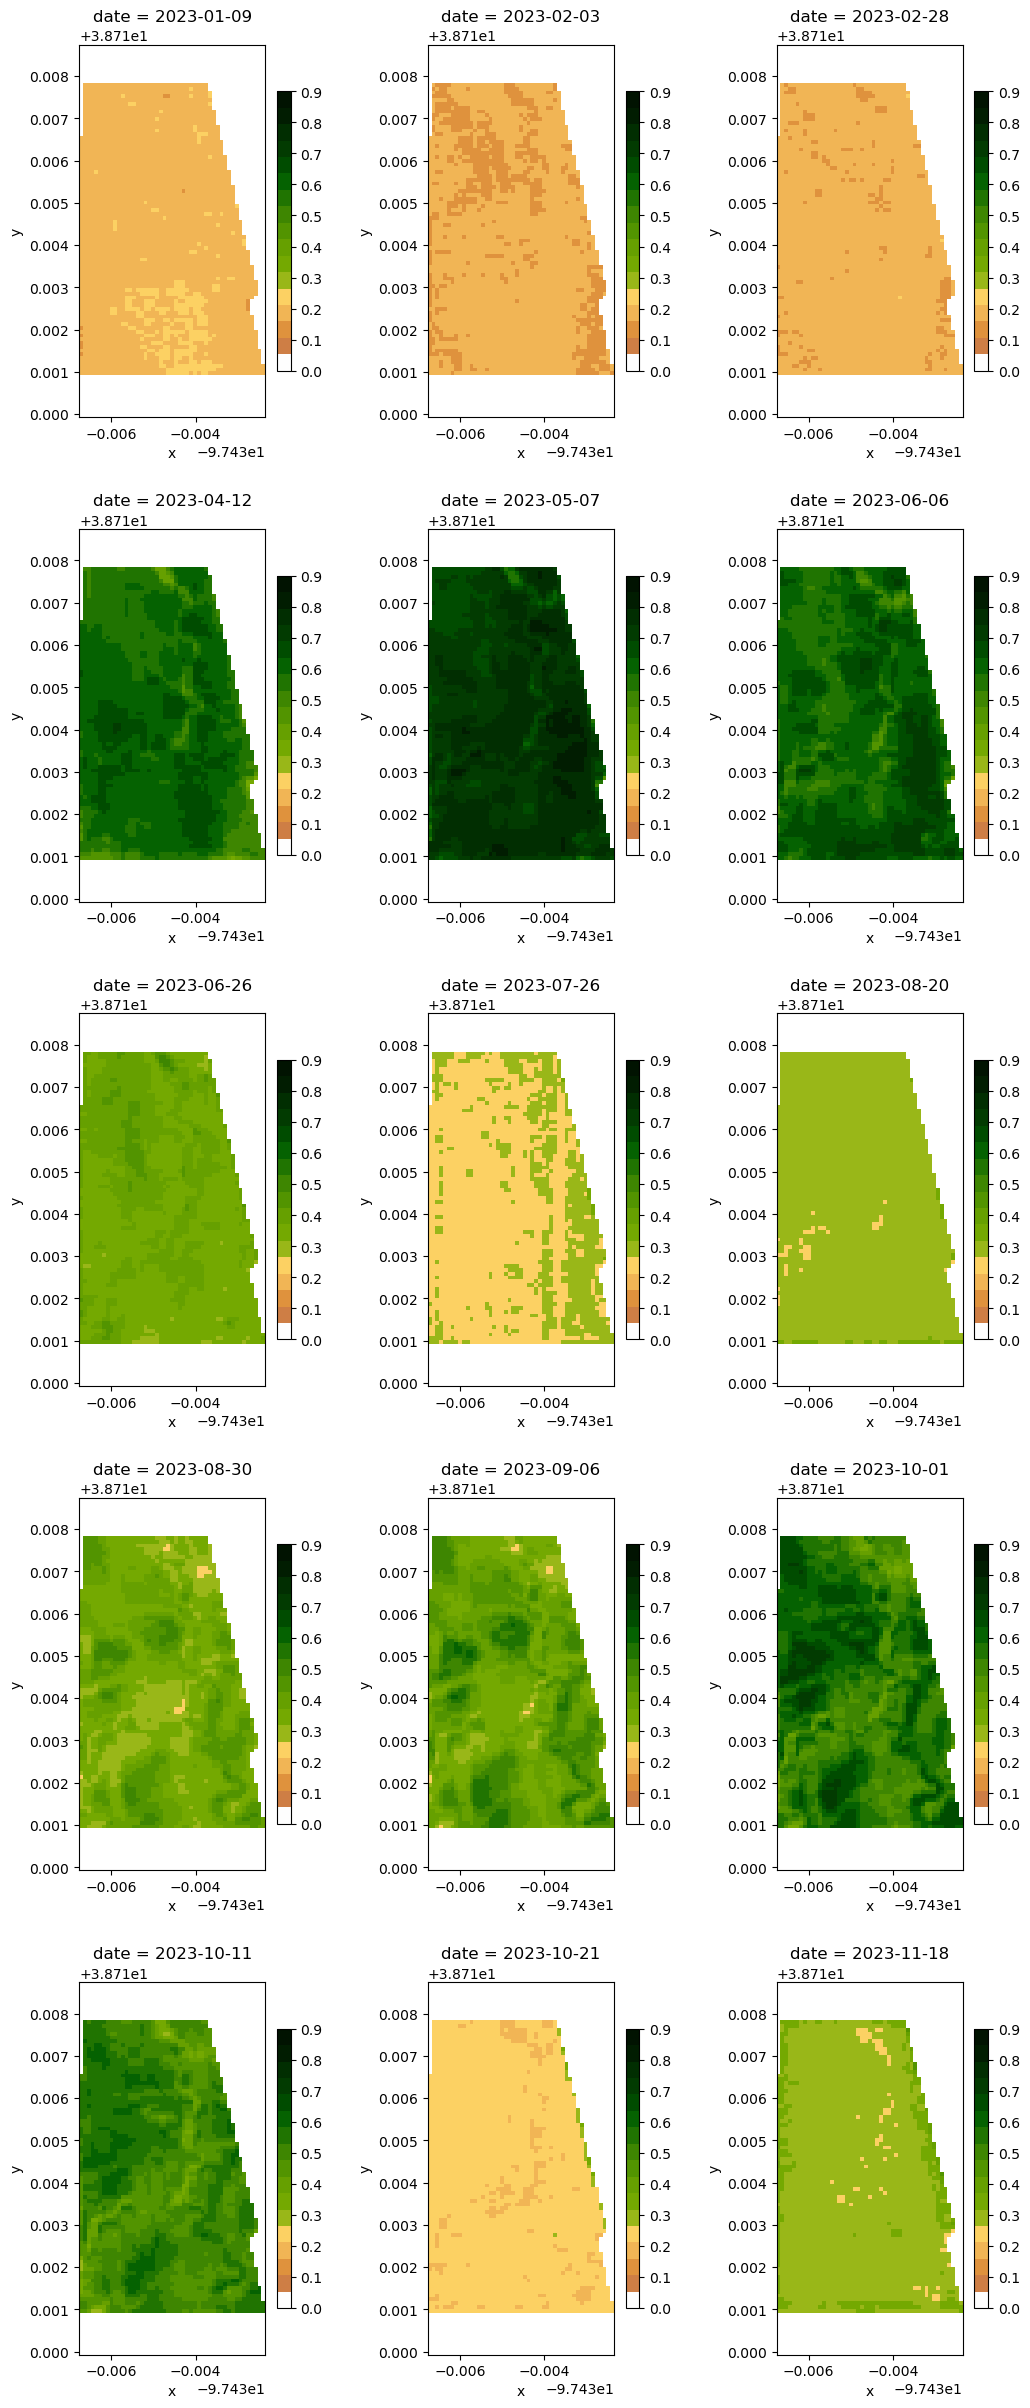

In [21]:
# Plot all of them
fig, axs = plt.subplots(figsize=(12, 30), nrows=5, ncols=3)
for n,ax in enumerate(axs.flat):
    data.sel(date=selected_dates[n]).plot(ax=ax, vmin=0.0, vmax=0.9, cmap=ndvi_cmap, cbar_kwargs={"shrink":0.75})
    ax.axis('equal')
    
fig.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()

### Access and select data within DataArray

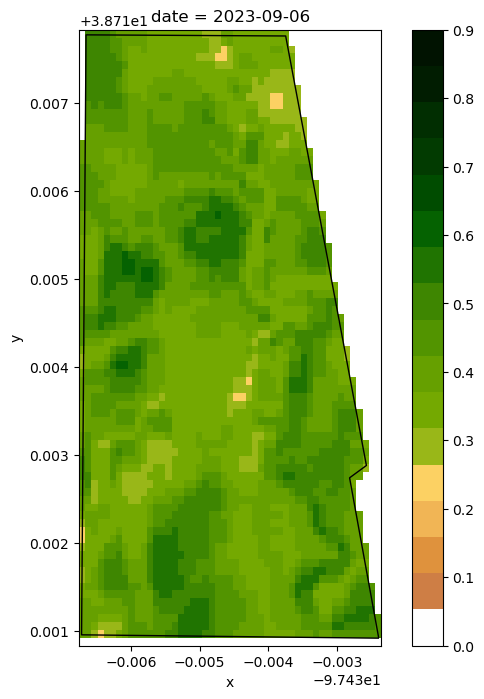

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
data.sel(date='2023-09-06').plot(ax=ax, cmap=ndvi_cmap, vmin=0.0, vmax=0.9)
field_bnd.plot(ax=ax, facecolor='None')
plt.show()


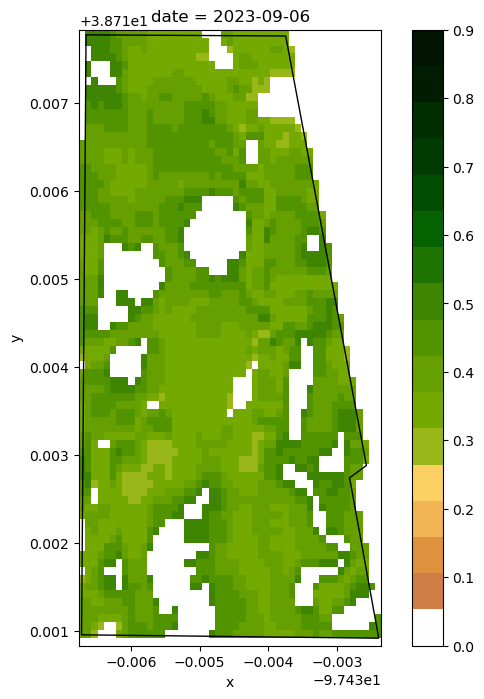

In [23]:
# Only areas with specific NDVI
fig, ax = plt.subplots(figsize=(8,8))
data.where((data.values>0.3) & (data.values<0.5)).sel(date='2023-09-06').plot(ax=ax, cmap=ndvi_cmap, vmin=0.0, vmax=0.9)
field_bnd.plot(ax=ax, facecolor='None')
plt.show()

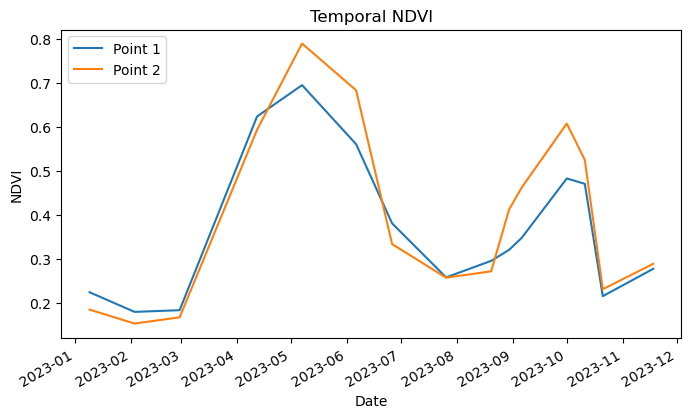

In [24]:
fig, ax = plt.subplots(figsize=(8,4))
data.sel(x=-97.434471, y=38.711997, method='nearest').plot(label='Point 1')
data.sel(x=-97.434268, y=38.715972, method='nearest').plot(label='Point 2')
ax.legend(loc='upper left')
ax.set_title('Temporal NDVI')
ax.set_xlabel('Date')
ax.set_ylabel('NDVI')
plt.show()


### Compute relative difference

For each NDVI layer we will normalize the values by first subtracting the mean, and then dividing by the mean. This was we will obtain a new grid showing areas of the field that have more or less biomass than teh field average.

$$ RD = \frac{NDVI - \overline{NDVI}}{\overline{NDVI}}$$


In [25]:
compute_rel_diff = lambda x: (x - np.nanmean(x))/np.nanmean(x)

In [26]:
# Compute relative difference
rel_diff = np.full((img_rows, img_cols, len(selected_dates)), np.nan)
for k,file in enumerate(files):
    da = xr.load_dataarray(file).squeeze()
    rel_diff[:,:,k] = compute_rel_diff(da.values)

In [27]:
rel_diff = xr.DataArray(data=rel_diff, 
                        coords=[da.y, da.x, pd.to_datetime(selected_dates)],
                        dims=["y", "x", "date"])

In [28]:
# Compute mean relative difference
mean_rel_diff = rel_diff.mean(axis=2)


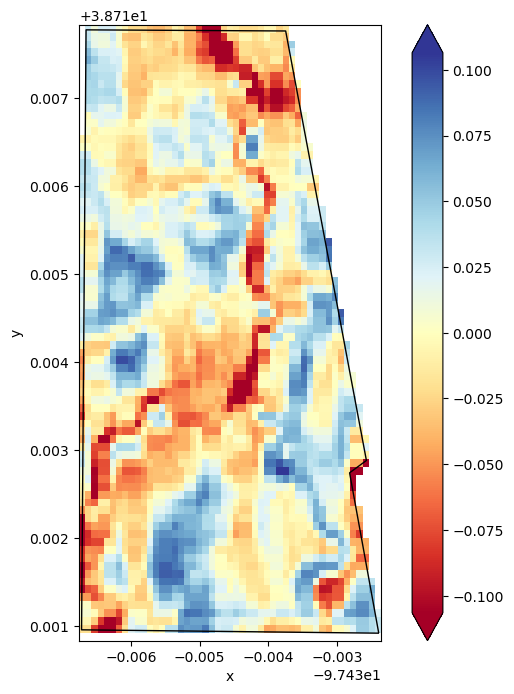

In [29]:
# Plot mean relative difference
fig, ax = plt.subplots(figsize=(8,8))
mean_rel_diff.plot(ax=ax, cmap='RdYlBu', robust=True)
field_bnd.plot(ax=ax, facecolor='None')
plt.show()



### Find management zones

We will use clustering analysis to find homogeneous management zones.

In [30]:
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.impute import SimpleImputer

import os
os.environ["OMP_NUM_THREADS"] = '1'


In [31]:
# Input data using all surveys
clustering_input_data = rel_diff.values.reshape(-1, len(selected_dates))

# Input clustering data is the resulting mean relative difference
#clustering_input_data = field_mrd.values.reshape(-1, 1)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # The goal is to place a value that does not affect the clustering result
data_imputed = imputer.fit_transform(clustering_input_data)

In [32]:
#clusterer = KMeans(n_clusters=3, random_state=1)
clusterer = BisectingKMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(data_imputed)
cluster_labels = cluster_labels.reshape(mean_rel_diff.shape).astype(float)

cluster_labels = np.round(gaussian_filter(cluster_labels, sigma=1.0))

# Restore NaNs
#cluster_labels[field_mask] = np.nan


C:\Users\ghintz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_bisect_k_means.py:245: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


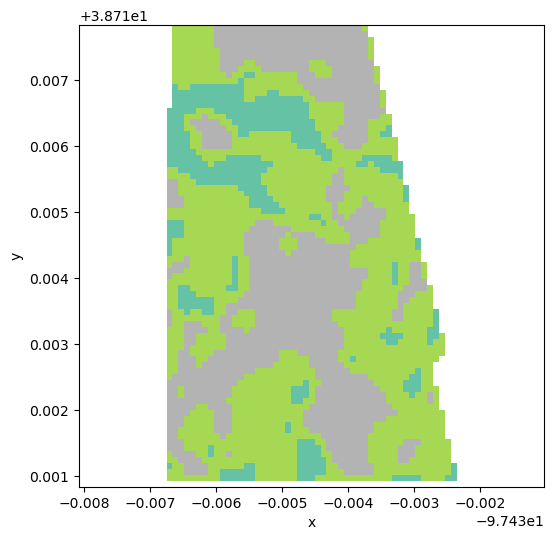

In [33]:

mz = xr.DataArray(data=cluster_labels,  coords=[da.y, da.x], dims=["y", "x"])
idx_nan = np.isnan(da)
mz.values[idx_nan] = np.nan

fig, ax = plt.subplots(figsize=(6,6))
mz.plot(ax=ax, cmap='Set2', add_colorbar=False)
ax.axis('equal')
plt.show()

In [34]:
mapped_clusters = xr.full_like(mz, np.nan)

for label in np.unique(mz):
    idx_cluster = mz == label
    cluster_mean = np.nanmedian(mean_rel_diff.values[idx_cluster])
    mapped_clusters.values[idx_cluster] = cluster_mean

C:\Users\ghintz\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


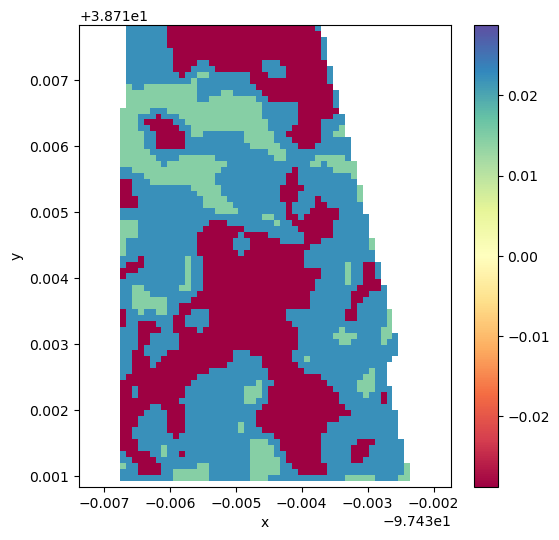

In [35]:
fig, ax = plt.subplots(figsize=(6,6))
mapped_clusters.plot(ax=ax, cmap='Spectral', add_colorbar=True)
ax.axis('equal')
plt.show()

### Vectorize resulting raster management zones

In [36]:
import rasterio.features
from shapely.geometry import shape

In [37]:
polygons = []
values = []

for label in np.unique(mz):
    idx_cluster = mz == label
    for geom, cluster_value in rasterio.features.shapes(mapped_clusters.values.astype(np.float32), mask=idx_cluster, transform=mz.rio.transform()):
        polygons.append(shape(geom))  # Convert the geometry to a Shapely polygon
        values.append(cluster_value)  # Store the cluster label (value)

# Create a GeoDataFrame with the polygons and their cluster labels
gdf = gpd.GeoDataFrame({'geometry': polygons, 'mrd_value': values}, crs=4326)

In [38]:
gdf

,geometry,mrd_value
0,"POLYGON ((-97.43559 38.71712, -97.43559 38.717...",0.014543
1,"POLYGON ((-97.43343 38.71631, -97.43334 38.716...",0.014543
2,"POLYGON ((-97.43379 38.71586, -97.43334 38.715...",0.014543
3,"POLYGON ((-97.43568 38.71703, -97.43559 38.717...",0.014543
4,"POLYGON ((-97.43316 38.71541, -97.43316 38.715...",0.014543
5,"POLYGON ((-97.43460 38.71496, -97.43460 38.714...",0.014543
6,"POLYGON ((-97.43442 38.71487, -97.43442 38.714...",0.014543
7,"POLYGON ((-97.43676 38.71487, -97.43676 38.714...",0.014543
8,"POLYGON ((-97.43298 38.71460, -97.43298 38.714...",0.014543
9,"POLYGON ((-97.43334 38.71424, -97.43334 38.713...",0.014543


<Axes: >

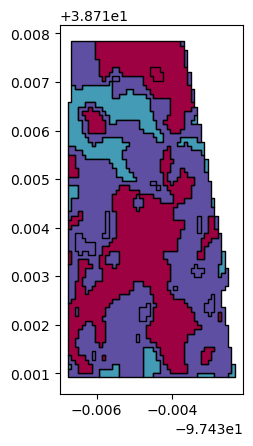

In [39]:
gdf.plot(column='mrd_value', edgecolor='k', cmap='Spectral', vmin=-0.02, vmax=0.02)

In [40]:
# Export shapefile as prescription map
gdf.to_file('outputs/prescription_mortimers.shp')

## Inspect soil moisture surveys

In [41]:
df_sm = pd.read_csv('sm_data/soil_moisture_surveys.csv', parse_dates=['TimeStamp'])
df_sm.head(3)


,TimeStamp,Record,Zone,Latitude,Longitude,Moisture,Period,Attenuation,Permittivity,Probe Model,Sensor,Probe_Model,Period ( us ),Period
0,2017-05-09 07:08:00,56,ZONE 00006,38.71096,-97.43689,28.65,1.5541,1.3962,15.7012,NaN,NaN,CD659 12cm rods,NaN,NaN
1,2017-05-09 07:08:00,57,ZONE 00006,38.71095,-97.43687,28.65,1.5541,1.3962,15.7012,NaN,NaN,CD659 12cm rods,NaN,NaN
2,2017-05-09 07:08:00,58,"ZONE 00006, ZONE 00007",38.71094,-97.43653,24.31,1.4886,1.2611,13.0000,NaN,NaN,CD659 12cm rods,NaN,NaN


In [42]:
# Define correction function based on Patrignani et al. (2022) for Hydrosense II hand-held sensor
correction_fn = lambda x: -0.0974 + (0.0735 * np.sqrt(x))**0.78


In [43]:
# Apply correction function
df_sm['Moisture_corrected'] = correction_fn(df_sm['Permittivity'])


### Create GeoDataframe
We will now convert the Pandas Dataframe into a GeoPandas GeoDataframe.

In [49]:
points = gpd.points_from_xy(df_sm['Longitude'], df_sm['Latitude'], crs="EPSG:4326")
field_points = gpd.GeoDataFrame(df_sm, geometry=points)
print(field_points.shape)
field_points.head(5)

(2687, 16)


,TimeStamp,Record,Zone,Latitude,Longitude,Moisture,Period,Attenuation,Permittivity,Probe Model,Sensor,Probe_Model,Period ( us ),Period,Moisture_corrected,geometry
0,2017-05-09 07:08:00,56,ZONE 00006,38.71096,-97.43689,28.65,1.5541,1.3962,15.7012,NaN,NaN,CD659 12cm rods,NaN,NaN,0.284648,POINT (-97.43689 38.71096)
1,2017-05-09 07:08:00,57,ZONE 00006,38.71095,-97.43687,28.65,1.5541,1.3962,15.7012,NaN,NaN,CD659 12cm rods,NaN,NaN,0.284648,POINT (-97.43687 38.71095)
2,2017-05-09 07:08:00,58,"ZONE 00006, ZONE 00007",38.71094,-97.43653,24.31,1.4886,1.2611,13.0000,NaN,NaN,CD659 12cm rods,NaN,NaN,0.257529,POINT (-97.43653 38.71094)
3,2017-05-09 07:09:00,59,"ZONE 00006, ZONE 00007",38.71094,-97.43625,25.70,1.5078,1.2071,13.8298,NaN,NaN,CD659 12cm rods,NaN,NaN,0.266199,POINT (-97.43625 38.71094)
4,2017-05-09 07:09:00,60,ZONE 00007,38.71094,-97.43597,28.63,1.5519,1.2712,15.6838,NaN,NaN,CD659 12cm rods,NaN,NaN,0.284483,POINT (-97.43597 38.71094)


In [50]:
# Convert geographic coordinates to projected coordinates 
# We will use UTM-14 for Kansas (https://epsg.io/32614)
field_points = field_points.to_crs(crs=32614)


In [53]:
# Approximate field boundary using the convex hull
field_bnd = gpd.GeoDataFrame(geometry=[field_points.unary_union.convex_hull])

# Alternatively you can read your field boundary in geojson, KML, or shapefile format
# field_bnd = gpd.read_file('sm_data/neon_kona_bnd.geojson').to_crs(crs=32614)


<Axes: >

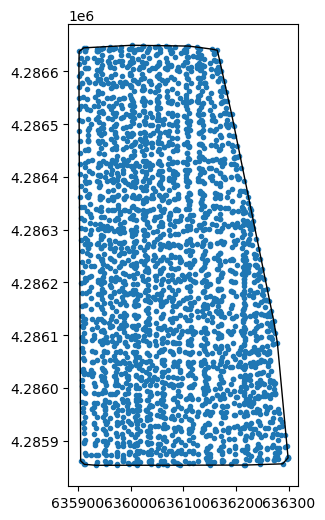

In [54]:
# Display all field points and the field boundary
fig, ax = plt.subplots(figsize=(6,6))
field_points.plot(ax=ax, marker='.')
field_bnd.plot(ax=ax, facecolor='None')


### Create field grid
Now need to generate a raster layer that spans the entire field, with each grid cell containing a value estimated from nearby point observations.

In [55]:
# Get bounds considering all points (note that bounds is for each geometry, while total bounds is for the entire GeoDataFrame)
xmin, ymin, xmax, ymax = field_points.total_bounds


In [56]:
# Create grid
xdelta = 5 # meters
ydelta = 5 # meters

xspacing = round((xmax-xmin)/xdelta)
yspacing = round((ymax-ymin)/ydelta)

xvec = np.linspace(xmin,xmax,xspacing)
yvec = np.linspace(ymin,ymax,yspacing)

X_grid,Y_grid = np.meshgrid(xvec,yvec)
Z_grid = np.full_like(X_grid, np.nan)


In [57]:
# Create raster using xarray
field_grid = xr.DataArray(Z_grid, coords=[yvec, xvec], dims=["y", "x"])
field_grid


<xarray.DataArray (y: 159, x: 79)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 4.286e+06 4.286e+06 4.286e+06 ... 4.287e+06 4.287e+06
  * x        (x) float64 6.359e+05 6.359e+05 6.359e+05 ... 6.363e+05 6.363e+05

In [58]:
# Create a GeoDataframe with the centroids, so that we can use them to find cells inside and outside of the field boundary
xy_points = gpd.points_from_xy(X_grid.flatten(), Y_grid.flatten(), crs=32614)
field_grid_centroids = gpd.GeoDataFrame(geometry=xy_points)


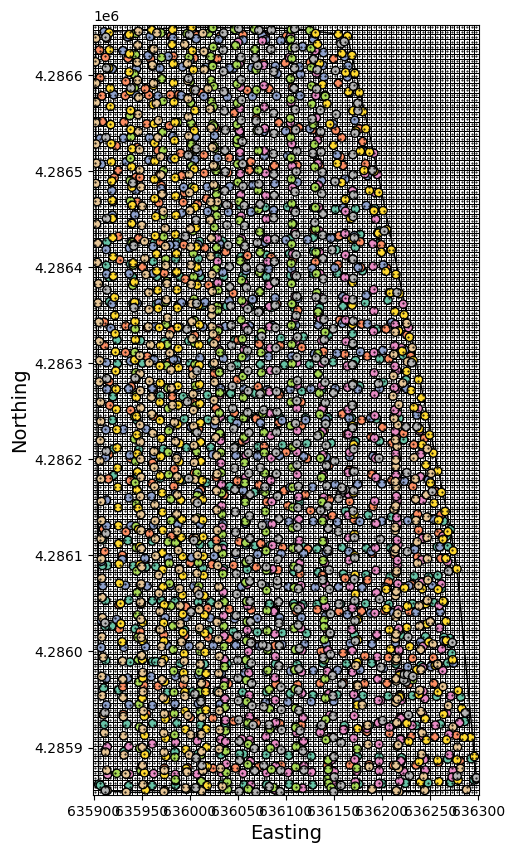

In [59]:
# Overlay all vector (sampling points ) and raster data
fig, ax = plt.subplots(figsize=(10,10))
field_grid.plot(ax=ax, edgecolor='k', linewidth=0.5, add_colorbar=False)
field_bnd.plot(ax=ax, color='None')
field_points.plot(ax=ax, edgecolor='k', marker='o', c=field_points['TimeStamp'].dt.dayofyear, cmap='Set2')
field_grid_centroids.plot(ax=ax, marker='.', markersize=1, color='k')
ax.set_xlabel('Easting', fontsize=14)
ax.set_ylabel('Northing', fontsize=14)
plt.show()


### Create mask
The mask represents the grid cells that are outside of the field boundary and that therefore we want to ignore during interpolation and the overall data analysis.

In [60]:
# Find grid points inside of field boundary
field_mask = ~field_grid_centroids.within(field_bnd['geometry'].iloc[0]) # For a one-to-many we need to pass the Shapely polygon
#field_mask = gdf_grid.geometry.apply(field_bnd['geometry'].iloc[0].contains) # Alternative using the contains method

# Convert the GeoSeries (1D column) to matrix form (2d array)
field_mask = np.reshape(field_mask.values, X_grid.shape)

# Convert array into Xarray
field_mask = xr.DataArray(field_mask, coords=[yvec, xvec], dims=["y", "x"])


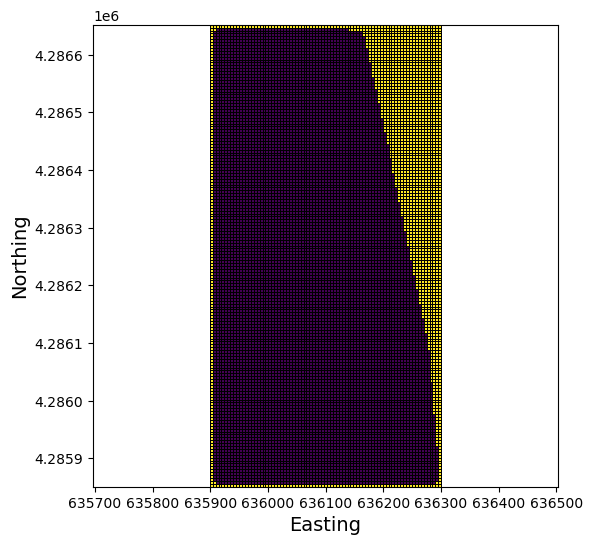

In [61]:
fig, ax = plt.subplots(figsize=(6,6))
field_mask.plot(ax=ax, edgecolor='k', linewidth=0.5, add_colorbar=False)
ax.set_xlabel('Easting', fontsize=14)
ax.set_ylabel('Northing', fontsize=14)
ax.axis('equal')
plt.show()


### Interpolate soil moisture for each survey
Here we will interpolate point values collected during each survey to the regular grid. There will be one grid per survey.


In [62]:
unique_survey_dates = field_points['TimeStamp'].dt.date.unique()
all_grids = np.empty((X_grid.shape[0], X_grid.shape[1], len(unique_survey_dates)))

for k,survey_date in enumerate(unique_survey_dates):
    idx_survey = field_points['TimeStamp'].dt.date == survey_date

    xp = field_points.get_coordinates().loc[idx_survey,'x'].values
    yp = field_points.get_coordinates().loc[idx_survey,'y'].values
    zp = field_points.loc[idx_survey,'Moisture_corrected'].values

    # Use a radial basis function interpolator
    xp += np.random.normal(0, 1e-6, size=xp.shape) # Need to add noise to avoid singularity due to points with same coordinates (sensor had 3 m GPS receiver)
    yp += np.random.normal(0, 1e-6, size=yp.shape)
    rbf = RBFInterpolator(np.column_stack((xp,yp)), zp, kernel='linear', neighbors=20) # cubic and think_place_spline give some badly interpolated maps
    interp_survey = rbf(np.column_stack((X_grid.flatten(), Y_grid.flatten())))
    interp_survey = interp_survey.reshape(X_grid.shape)
    
    # Use griddata
    #interp_survey = griddata((xp, yp), zp, (X_grid, Y_grid), method='linear')

    # Replace values outside field boundary with NaN
    interp_survey[field_mask] = np.nan

    # Compute the relative difference
    interp_survey_norm =  (interp_survey - np.nanmean(interp_survey))/np.nanmean(interp_survey)
    
    # Append interpolated grid
    all_grids[:,:,k] = interp_survey_norm

In [63]:
# Create a space-time DataArray with all the interpolated surveys
field_interp_grids = xr.DataArray(all_grids, coords=[yvec, xvec, unique_survey_dates], dims=["y", "x", "date"])


In [64]:
# Plot particular survey
#field_interp_grids.sel(date=unique_survey_dates[1]).plot()


In [65]:
print(len(unique_survey_dates))

7


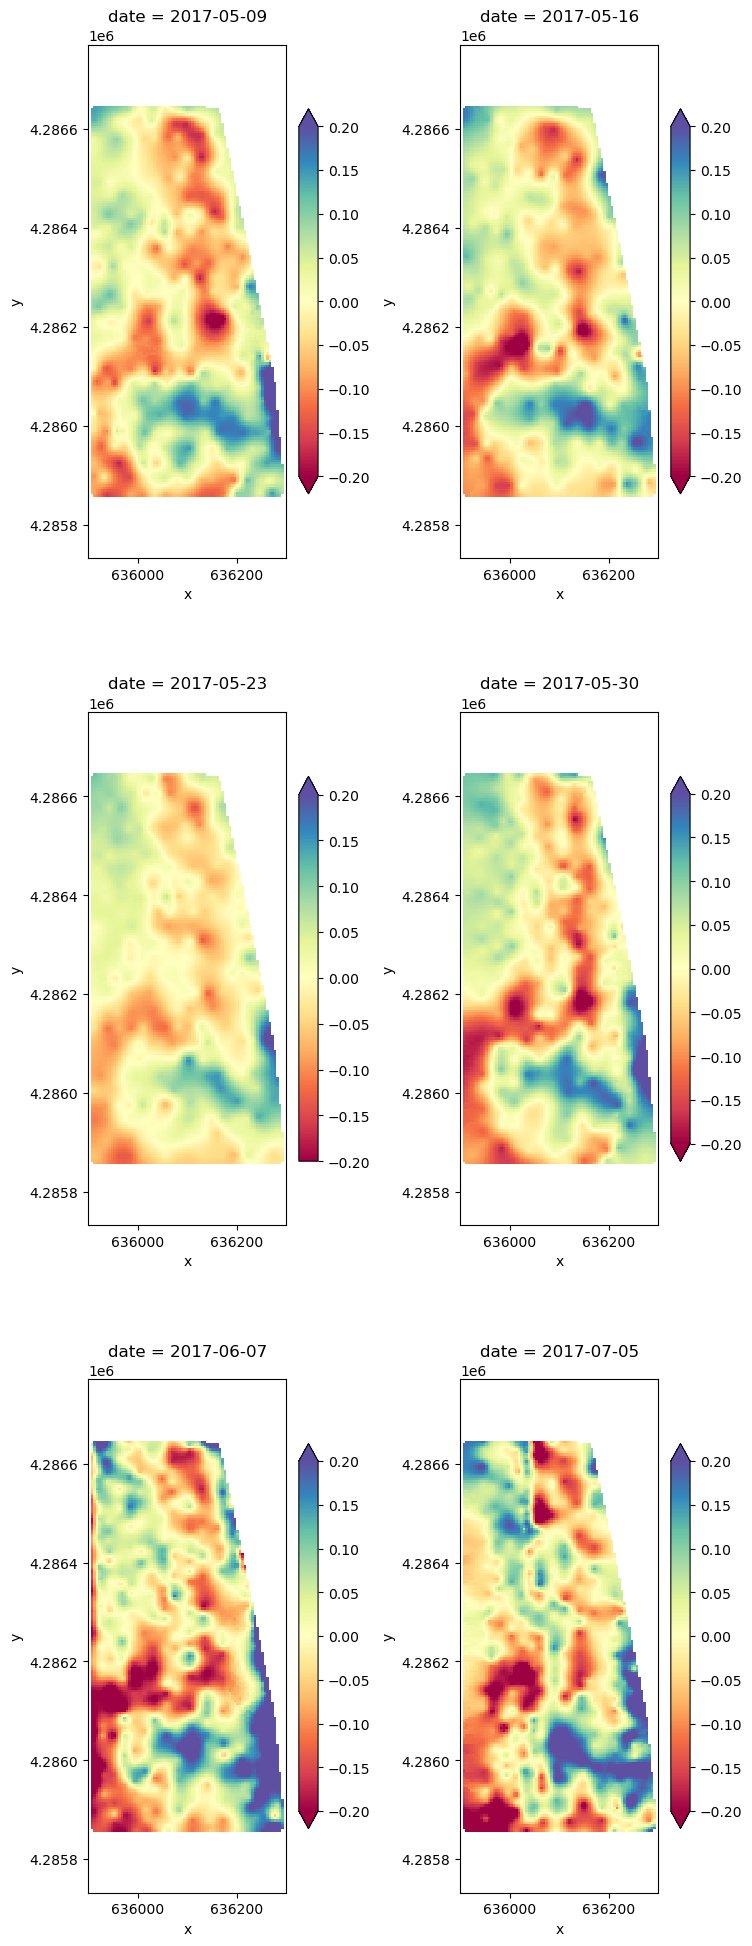

In [66]:
# Plot all of them
fig, axs = plt.subplots(figsize=(8, 24), nrows=3, ncols=2)
for n,ax in enumerate(axs.flat):
    field_interp_grids.sel(date=unique_survey_dates[n]).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='Spectral', cbar_kwargs={"shrink":0.75})
    ax.axis('equal')
    
fig.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()

In [67]:
# Compute mean relative diffences
field_mrd = field_interp_grids.mean(axis=2)
field_sd = field_interp_grids.std(axis=2)


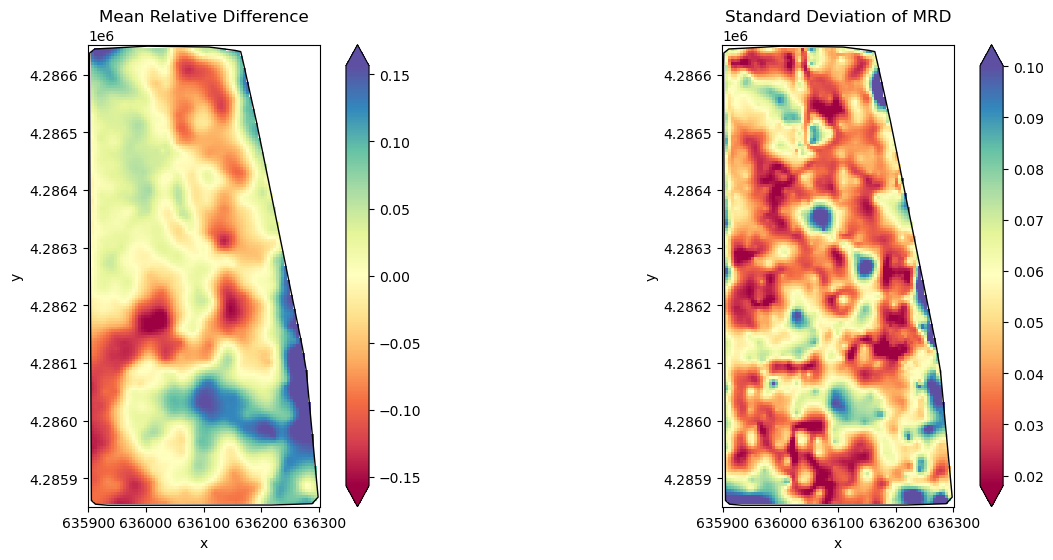

In [68]:
fig, ax = plt.subplots(figsize=(15,6), nrows=1, ncols=2)
field_mrd.plot(ax=ax[0], cmap='Spectral', robust=True)
field_bnd.plot(ax=ax[0], facecolor='None', edgecolor='k', linewidth=1)
ax[0].set_title('Mean Relative Difference')

field_sd.plot(ax=ax[1], cmap='Spectral', robust=True)
field_bnd.plot(ax=ax[1], facecolor='None', edgecolor='k', linewidth=1)
ax[1].set_title('Standard Deviation of MRD')

plt.show()


### Determine management zones based on soil moisture

In [ ]:
# To do by students following NDVI example